
# Preprocessing for MIT data (Binary classification) with MinMax Scaler and Oversamling
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.


Processing **steps** for MIT dataset:   
    resample: Oversampling  
    rescaling: MinMaxScaler  


**Input** : Cleaned data with dummy target variable.   
mitbih_test.csv   
mitbih_train.csv

**Output** : Sampled and Scaled data with dummy target:   
mitbih_train_clean_minmax_oversampling.csv  
mitbih_test_clean_minmax_oversampling.csv


In [12]:
import sys
import os
data_path = ''
data_output_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q


    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'


Running on local environment
Current working directory: c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\notebooks


In [13]:
# Verify installation and import libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler


RawFiles = dict({
    'test': data_path +  'mitbih_test.csv', # MIT data set in which we have dummy-coded the target variable
    'train': data_path +  'mitbih_train.csv', # MIT data set in which we have dummy-coded the target variable
})

OutputFiles = dict({
    'test': data_output_path + 'mitbih_test_shift_multiclass_minmax_oversampling.csv',
    'train': data_output_path + 'mitbih_train_shift_multiclass_minmax_oversampling.csv',
})


In [14]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df
def convertColumnAsInt(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce') # convert to numeric to handle NaN values
    df.dropna(subset=[column], inplace=True)  # drop the rows with NaN values
    df[column] = df[column].astype(int)  # convert to int
    return df

In [15]:
mitbih_train = pd.read_csv(RawFiles.get('train'), header=None ) 
mitbih_test = pd.read_csv(RawFiles.get('test'), header=None )

mitbih_train = addColumnsToDataframe(mitbih_train)
mitbih_train = convertColumnAsInt(mitbih_train, 'target')

mitbih_test = addColumnsToDataframe(mitbih_test)
mitbih_test = convertColumnAsInt(mitbih_test, 'target')

# # target value and meanings
# all_class_mapping = {
#     0: 'Normal',
#     1: 'Supraventricular',
#     2: 'Ventricular',
#     3: 'Fusion',
#     4: 'Unclassifiable'
# }
# mitbih_train['target'] = mitbih_train['target'].map(all_class_mapping)
# mitbih_test['target'] = mitbih_test['target'].map(all_class_mapping)
# # Drop rows where 'target' is 'Unclassifiable beat'
# mitbih_train = mitbih_train[mitbih_train['target'] != 'Unclassifiable']
# mitbih_test = mitbih_test[mitbih_test['target'] != 'Unclassifiable']


# # convert to binary classification Combine abnormal categories
# mitbih_train['target'] = mitbih_train['target'].replace(['Supraventricular', 'Ventricular', 'Fusion'], 'abnormal')
# mitbih_test['target'] = mitbih_test['target'].replace(['Supraventricular', 'Ventricular', 'Fusion'], 'abnormal')

# # Encode the labels: normal as 0, abnormal as 1
# mitbih_train['target'] = mitbih_train['target'].replace({'Normal': 0, 'abnormal': 1})
# mitbih_test['target'] = mitbih_test['target'].replace({'Normal': 0, 'abnormal': 1})

# # target value and meanings
# # class_mapping = {
# #     0: 'Normal',
# #     1: 'Abnormal'
# # }

#drop null value  
mitbih_train = mitbih_train.dropna(how='any')
mitbih_test = mitbih_test.dropna(how='any')




In [16]:
mitbih_train["target"].value_counts()

target
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64

In [17]:
mitbih_test["target"].value_counts()

target
0    18118
4     1608
2     1448
1      556
3      162
Name: count, dtype: int64

## Shift data

In [18]:
import pandas as pd
from scipy.signal import find_peaks
import os
import numpy as np

# Function to find the Top-N highest and lowest peaks in a single signal
def find_top_n_peaks(signal, n=5):
    # Find highest peaks
    high_peaks, _ = find_peaks(signal)
    high_peaks_values = signal[high_peaks]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:n]

    # Find lowest peaks 
    low_peaks, _ = find_peaks(signal * -1)  # Peaks in the negative of the signal
    low_peaks_values = signal[low_peaks]
    top_low_peaks = sorted(zip(low_peaks, low_peaks_values), key=lambda x: x[1])[:n]

    return top_high_peaks, top_low_peaks

# Function to find global Top-N peaks across the entire dataset (for each row)
def find_global_top_peaks(data, n=5):
    top_high_peaks_global = []
    top_low_peaks_global = []

    for _, row in data.iterrows():
        signal = row.values
        top_high_peaks, top_low_peaks = find_top_n_peaks(signal, n)
        top_high_peaks_global.append(top_high_peaks)
        top_low_peaks_global.append(top_low_peaks)

    return top_high_peaks_global, top_low_peaks_global

# Function to align signals based on a specific peak index
def align_signals(data, peak_index, target_column=None):
    if target_column is None:
        target_column = data.shape[1] // 2

    aligned_data = []
    for _, row in data.iterrows():
        # Calculate the shift required based on the peak index
        shift = target_column - peak_index
        shifted_row = np.roll(row, shift)
        aligned_data.append(shifted_row)

    return pd.DataFrame(aligned_data)

# Target column name
target_column = 'target'
target_classes = mitbih_train[target_column].unique()

# Combined DataFrames for training and test datasets
combined_train_data = []
combined_test_data = []

# Process each class in the training and test datasets
for c in target_classes:
    # Filter data by class
    train_class_data = mitbih_train[mitbih_train[target_column] == c].iloc[:, :-1]
    test_class_data = mitbih_test[mitbih_test[target_column] == c].iloc[:, :-1]

    # Find Top-5 highest and lowest peaks for the training dataset of the current class
    top_high_train, top_low_train = find_global_top_peaks(train_class_data, n=5)
    # Center signals on the first highest peak
    aligned_train_high = align_signals(train_class_data, top_high_train[0][0][0])  # Top-1 High Peak
    # Center signals on the first lowest peak
    aligned_train_low = align_signals(train_class_data, top_low_train[0][0][0])  # Top-1 Low Peak

    # Find Top-5 highest and lowest peaks for the test dataset of the current class
    top_high_test, top_low_test = find_global_top_peaks(test_class_data, n=5)
    # Center signals on the first highest peak
    aligned_test_high = align_signals(test_class_data, top_high_test[0][0][0])  # Top-1 High Peak
    # Center signals on the first lowest peak
    aligned_test_low = align_signals(test_class_data, top_low_test[0][0][0])  # Top-1 Low Peak
    
    # Combine high and low aligned versions (You may choose one or both alignments depending on your needs)
    aligned_train = (aligned_train_high + aligned_train_low) / 2
    aligned_test = (aligned_test_high + aligned_test_low) / 2

    # Add a column for the target variable
    aligned_train['target'] = c
    aligned_test['target'] = c

    # Append the aligned data to the final lists for training and test datasets
    combined_train_data.append(aligned_train)
    combined_test_data.append(aligned_test)

# Combine all classes into two final DataFrames (one for training, one for testing)
shifted_mit_train = pd.concat(combined_train_data).sample(frac=1).reset_index(drop=True)
shifted_mit_test = pd.concat(combined_test_data).sample(frac=1).reset_index(drop=True)

# Rename columns to c_0, c_1, ..., c_187, and 'target'
feature_columns = [f'c_{i}' for i in range(shifted_mit_train.shape[1] - 1)] + ['target']
shifted_mit_train.columns = feature_columns
shifted_mit_test.columns = feature_columns



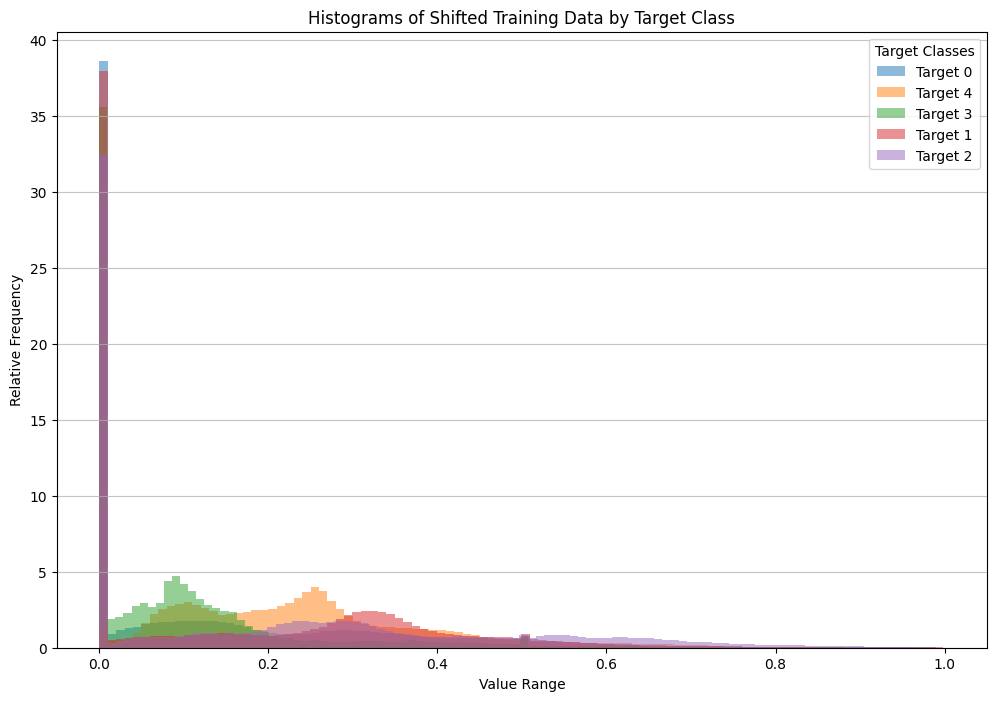

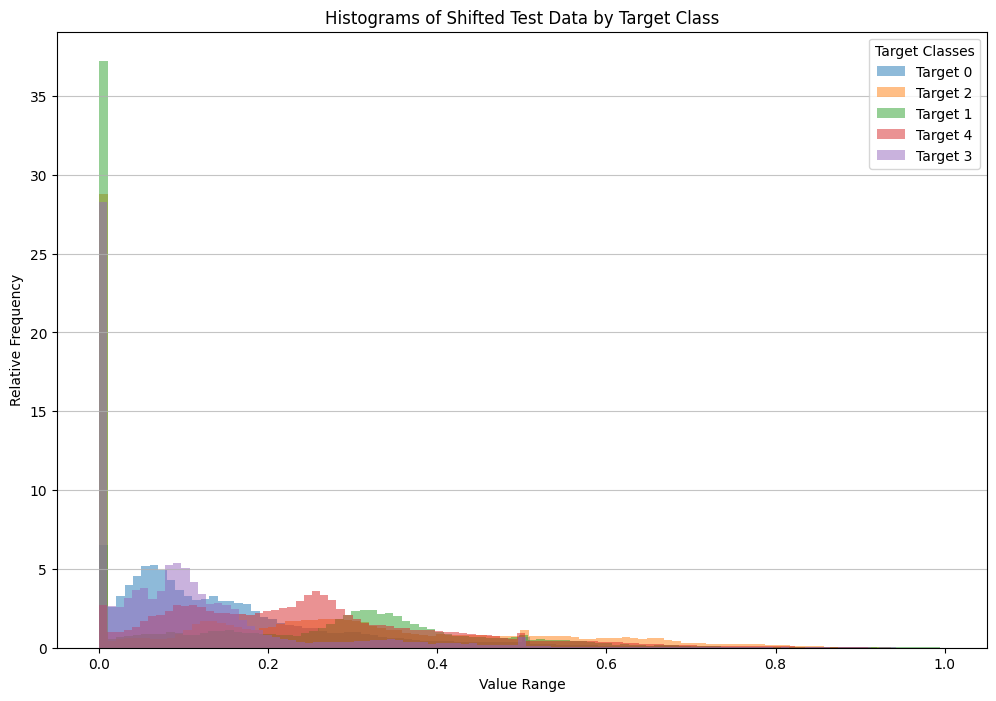

In [19]:
import matplotlib.pyplot as plt

# Function to create histograms by target class
def plot_histograms_by_target(data, target_column, title):
    classes = data[target_column].unique()
    
    plt.figure(figsize=(12, 8))
    for c in classes:
        # Extract data for the current class (excluding the target column)
        class_data = data[data[target_column] == c].iloc[:, :-1].values.flatten()
        
        # Plot histogram for the current class
        plt.hist(class_data, bins=100, alpha=0.5, label=f'Target {c}', density=True)
    
    plt.title(title)
    plt.xlabel("Value Range")
    plt.ylabel("Relative Frequency")
    plt.legend(title="Target Classes")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot histograms for shifted training data
plot_histograms_by_target(shifted_mit_train, 'target', "Histograms of Shifted Training Data by Target Class")

# Plot histograms for shifted test data
plot_histograms_by_target(shifted_mit_test, 'target', "Histograms of Shifted Test Data by Target Class")


In [20]:
# split train test set before resampling

X_train = shifted_mit_train.drop(columns=['target'], inplace=False) # drop the target column
X_test = shifted_mit_test.drop(columns=['target'], inplace=False) # drop the target column

y_train = shifted_mit_train['target'] # only the target column
y_test = shifted_mit_test['target'] # only the target column


# Resampling the train data with Oversampling before scaling with MinMaxScaler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Scaling with MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [21]:
# convert resampling rescaling data back to dataframe to concat
X_train_scaled_df =  pd.DataFrame(X_train_scaled, columns=[f'c_{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'c_{i}' for i in range(X_test_scaled.shape[1])])
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['target'])
y_test_df = pd.DataFrame(y_test, columns=['target']) 


# concat X_train, y_train/ X_test, y_test
shift_mitbih_train_multiclass_clean_default = pd.concat(
    [
        X_train_scaled_df,
        y_train_resampled_df
    ], axis=1)

shift_mitbih_test_multiclass_clean_default = pd.concat(
    [  
        X_test_scaled_df,
        y_test_df.reset_index(drop=True)
    ], axis=1)



In [ ]:
# Save data to CSV
shift_mitbih_train_multiclass_clean_default.to_csv(OutputFiles.get('train'), index=False)
shift_mitbih_test_multiclass_clean_default.to_csv(OutputFiles.get('test'), index=False)



In [23]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-01 12:24:17.121708
